<a href="https://colab.research.google.com/github/DilanDoshi/m148_heart_failure_predictors-/blob/main/M148_Heart_Failure_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M148 Heart Failure project (Deprecated) - Do not use
Cardiovascular diseases (CVDs) are the leading cause of death globally, responsible for an estimated 17.9 million deaths each year—approximately 31% of all deaths worldwide. Heart failure, a common consequence of CVDs, poses a major health burden that requires timely prediction and intervention. This project utilizes a dataset containing 12 clinical features to develop a machine learning model for predicting mortality due to heart failure. Early identification of high-risk patients through such predictive modeling can support proactive disease management and improve patient outcomes.

## Imports and Dataset

In [2]:
import numpy as np, pandas as pd, glob, os
import kagglehub

In [3]:
# Download latest version of dataset
path = kagglehub.dataset_download("andrewmvd/heart-failure-clinical-data")
print("Path to dataset: ", path)

100%|██████████| 3.97k/3.97k [00:00<00:00, 5.55MB/s]

Extracting files...
Path to dataset:  /root/.cache/kagglehub/datasets/andrewmvd/heart-failure-clinical-data/versions/1


In [4]:
# Store data into pd dataframe
df = pd.read_csv(os.path.join(path, "heart_failure_clinical_records_dataset.csv"))
print("Dataset shape: ", df.shape)
print(df.sum())
df.head(5)

Dataset shape:  (299, 13)
age                         1.818933e+04
anaemia                     1.290000e+02
creatinine_phosphokinase    1.739700e+05
diabetes                    1.250000e+02
ejection_fraction           1.138700e+04
high_blood_pressure         1.050000e+02
platelets                   7.874405e+07
serum_creatinine            4.167700e+02
serum_sodium                4.085100e+04
sex                         1.940000e+02
smoking                     9.600000e+01
time                        3.894800e+04
DEATH_EVENT                 9.600000e+01
dtype: float64


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis and Cleaning

In [18]:
# Check if we have missing values ('nan')
print(df.duplicated().sum())
df.isna().sum()

0


,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [6]:
# Data Cleaning: Checking for outliers

non_binary_columns = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
quantile_1 = df[non_binary_columns].quantile(0.25)
quantile_3 = df[non_binary_columns].quantile(0.75)
iqr = quantile_3 - quantile_1
lower_bound = quantile_1 - 1.5 * iqr
upper_bound = quantile_3 + 1.5 * iqr

outliers = (df[non_binary_columns] < lower_bound) | (df[non_binary_columns] > upper_bound)

print("Outliers: ")
outliers.sum()

Outliers: 


,0
creatinine_phosphokinase,29
ejection_fraction,2
platelets,21
serum_creatinine,29
serum_sodium,4


In [7]:
# Data Cleaning: Remove outliers

rows_w_outliers = outliers.any(axis=1)
df_clean = df[~rows_w_outliers] # return dataframe without outliers

df_clean.shape


(224, 13)

In [8]:
# Get rid of unncessary features after EDA

### EDA

In [9]:
import matplotlib.pyplot as plt

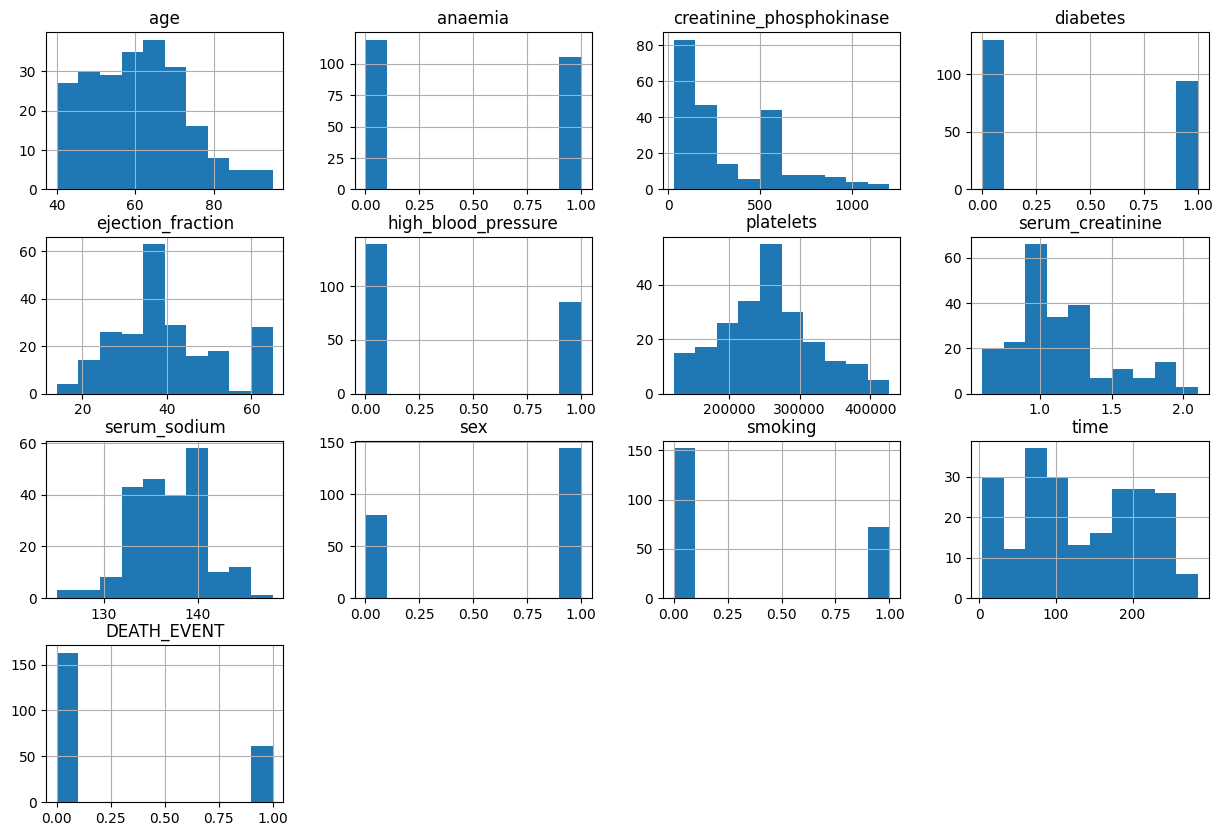

In [19]:
# Look at Data
df_clean.hist(figsize=(15,10))
plt.show()

<Axes: xlabel='diabetes'>

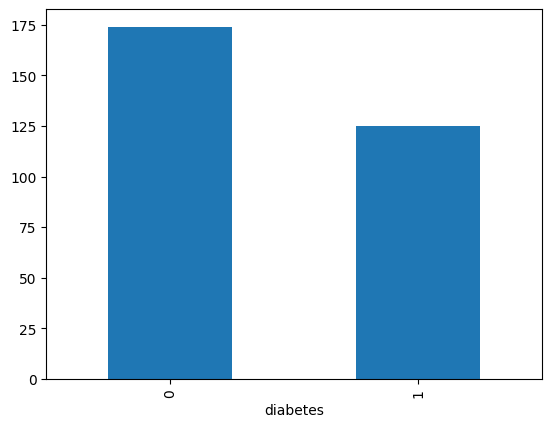

In [20]:
df['diabetes'].value_counts().plot(kind='bar')

Total deaths with diabetes:  24
Total deaths without diabetes:  37


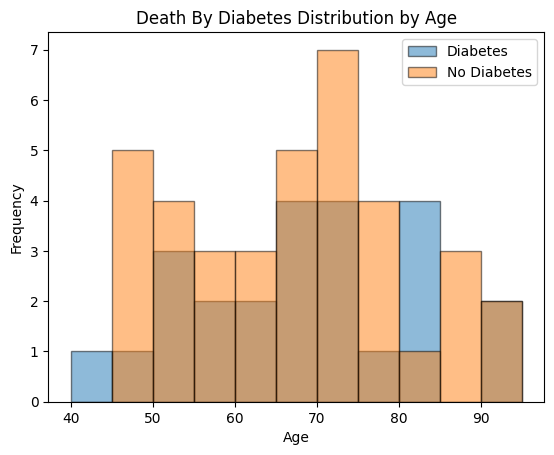

In [10]:
# Histogram: Diabetes against age

ages_with_diabetes = df_clean.loc[(df_clean['diabetes'] == 1) & (df_clean['DEATH_EVENT'] == 1), 'age']
ages_without_diabetes = df_clean.loc[(df_clean['diabetes'] == 0) & (df_clean['DEATH_EVENT'] == 1), 'age']
total_death_w_diabetes = len(ages_with_diabetes)
total_death_wo_diabetes = len(ages_without_diabetes)

print("Total deaths with diabetes: ", total_death_w_diabetes)
print("Total deaths without diabetes: ", total_death_wo_diabetes)


# Build 5-year bins covering the full age range
age_min = df_clean['age'].min()
age_max = df_clean['age'].max()

bins = np.arange(
    (age_min // 5) * 5,              # floor to nearest 5
    ((age_max + 4) // 5) * 5 + 5,    # ceil to nearest 5, then add one step
    5
)

plt.hist(ages_with_diabetes, bins=bins, alpha=0.5, label='Diabetes', edgecolor = 'black')
plt.hist(ages_without_diabetes, bins=bins, alpha=0.5, label='No Diabetes', edgecolor = 'black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Death By Diabetes Distribution by Age')
plt.legend()
plt.show()



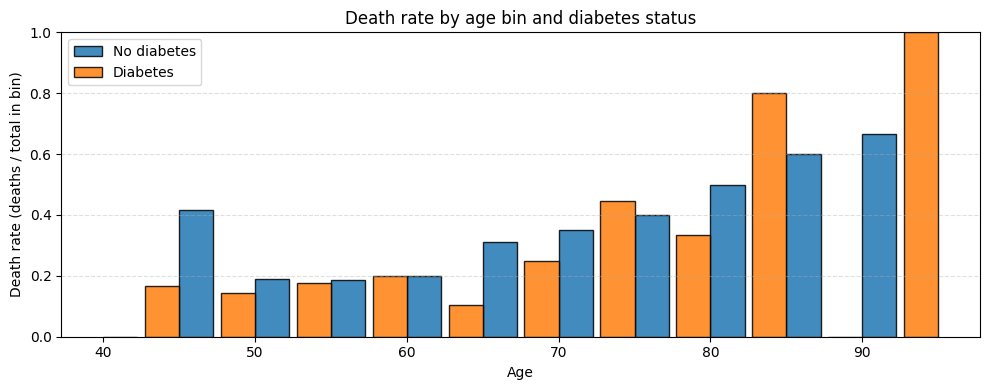

In [11]:
# Change to Death Rate

# Denominators:
total_age_w_diabetes = df_clean.loc[df_clean['diabetes'] == 1, 'age']
total_age_wo_diabetes = df_clean.loc[df_clean['diabetes'] == 0, 'age']

# Build common 5-year bins covering the data
age_min, age_max = df_clean['age'].min(), df_clean['age'].max()
bins = np.arange((age_min // 5) * 5, ((age_max + 4) // 5) * 5 + 5, 5)

death_d1, _ = np.histogram(ages_with_diabetes, bins=bins)
death_d0, _ = np.histogram(ages_without_diabetes, bins=bins)

total_d1, _ = np.histogram(total_age_w_diabetes, bins=bins)
total_d0, _ = np.histogram(total_age_wo_diabetes, bins=bins)

rate_d1 = np.divide(death_d1, total_d1, out=np.zeros_like(death_d1, dtype=float), where=total_d1 > 0)
rate_d0 = np.divide(death_d0, total_d0, out=np.zeros_like(death_d0, dtype=float), where=total_d0 > 0)

lefts  = bins[:-1]
widths = np.diff(bins)
w = widths * 0.45  # each bar ~45% of bin width

plt.figure(figsize=(10,4))
plt.bar(lefts, rate_d0, width=w, align='edge', label='No diabetes', edgecolor='black', alpha=0.85)
plt.bar(lefts + widths-w, rate_d1, width=w, align='edge', label='Diabetes',    edgecolor='black', alpha=0.85)
plt.xlabel('Age')
plt.ylabel('Death rate (deaths / total in bin)')
plt.ylim(0, 1)
plt.title('Death rate by age bin and diabetes status')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Death Rate between Male and Female:

male = df_clean.loc[df_clean['sex'] == 1, 'DEATH_EVENT']
female = df_clean.loc[df_clean['sex'] == 0, 'DEATH_EVENT']

print("Male Death Rate", male.mean())
print("Female Death Rate", female.mean())

Male Death Rate 0.2847222222222222
Female Death Rate 0.25


In [17]:
# Correlations
corr = df_clean.corr(numeric_only=True)
print("Regular Correlation Matrix")
print(corr)

corr_with_death = corr['DEATH_EVENT'].sort_values(ascending=False)
print("\n\nCorrelation with Death Event Matrix Using Pearson Method (Linear Correlation): ")
print(corr_with_death)

corr_with_death_spearman = df_clean.corr(method='spearman')['DEATH_EVENT'].sort_values(ascending=False)
print("\n\nCorrelation with Death Event Matrix Using Spearman Method (Non-Linear Correlation): ")
print(corr_with_death_spearman)


Regular Correlation Matrix
                               age   anaemia  creatinine_phosphokinase  \
age                       1.000000  0.053539                  0.029417   
anaemia                   0.053539  1.000000                 -0.204293   
creatinine_phosphokinase  0.029417 -0.204293                  1.000000   
diabetes                 -0.035489 -0.019261                  0.000761   
ejection_fraction         0.085668 -0.011293                 -0.124547   
high_blood_pressure       0.122613  0.021316                 -0.014055   
platelets                -0.090753  0.016587                  0.027437   
serum_creatinine          0.277358 -0.005744                  0.119707   
serum_sodium             -0.024793  0.073751                 -0.121298   
sex                       0.031341 -0.102687                 -0.058015   
smoking                  -0.003437 -0.148455                 -0.058020   
time                     -0.227897 -0.084116                  0.119300   
DEATH_EVENT

The results of these correlation coefficients reveals that death is influenced by many factors. As a result, the observed correlations with the death outcome are relatively weak. The Pearson correlation measures only linear associations, therefore, if the underlying relationships are nonlinear or threshold-dependent (for example, a sharp increase in mortality risk beyond a certain age), the resulting coefficients may not reflect that.    
  
Furthermore, several predictor variables, such as sex, smoking status, and diabetes, are binary, inherently constraining the possible range of correlation values. This shows that we need to combine multiple features to get the best results.